# INSTALL

In [ ]:
!pip3 install tinkoffpy -i https://artifactory.tcsbank.ru/artifactory/api/pypi/python-all/simple

!pip3 install tinkoffpy -i https://artifactory.tcsbank.ru/artifactory/api/pypi/python-all/simple --upgrade

#!pip install seaborn catboost nltk scikit-learn==1.2.2 catboost tinkoff scikit-uplift category_encoders imblearn shap optuna

!pip install --upgrade -i https://registry.tcsbank.ru/repository/pypi-all/simple featurestore

!python3 -m pip install "fsclient==0.2.19"
!pip install --force-reinstall --no-cache-dir scikit-learn

# IMPORTS 

In [2]:
import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import category_encoders as ce
import sklift
import json
import logging
from math import ceil
import time
# !pip install -q psycopg2-binary pandas
import psycopg2 as pg
from getpass import getpass
from sklearn.impute import SimpleImputer

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, confusion_matrix,
                             classification_report, roc_curve, precision_recall_curve)

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold

from sklift.metrics import uplift_at_k, uplift_by_percentile
from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.viz import plot_uplift_preds, plot_uplift_by_percentile, plot_qini_curve, plot_uplift_curve

sns.set(style='whitegrid', font_scale=1.5, palette='Set2')
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from causalml.inference.meta import BaseXLearner
from catboost import CatBoostClassifier

# Подготовка данных

Загружаем данные по результатам АБ тестирования 

In [5]:
df = pd.read_csv('data1.csv')

Для обучения оставим 1.43млн пользователей и 2 варианта бонусов (стандартный и повышенный в 4 раза) 
В обучении будут использоваться 222 пользовательских признаков 

In [6]:
df.shape

(1429898, 223)

Ниже представлен пример данных (не в настоящих единицах изменения)

In [9]:
data_features.head(5)

,party_rk,mpl_count,push_read_ratio,gender_rate,min_age,avg_age,median_monthly_income_amt,avg_children_cnt,avg_education_level,avg_sent_phone_amt,avg_rec_phone_amt,avg_sent_card_amt,avg_rec_card_amt,avg_payment_score_amt,avg_push_read_cnt,avg_push_delivered_cnt,avg_push_read_ratio,avg_email_delivered_cnt,avg_email_read_cnt,avg_email_unsubscribe_ratio,avg_email_read_ratio,cnt_trnx_3m,sum_trnx_3m,avg_trnx_3m,max_trnx_3m,cnt_trnx_7d,cnt_trnx_1m,sum_trnx_1m,avg_trnx_1m,max_trnx_1m,cnt_trnx_cur_3m,sum_trnx_cur_3m,avg_trnx_cur_3m,max_trnx_cur_3m,cnt_trnx_cur_7d,cnt_trnx_cur_1m,sum_trnx_cur_1m,avg_trnx_cur_1m,max_trnx_cur_1m,cnt_trnx_ccr_3m,cnt_trnx_ccr_7d,cnt_trnx_ccr_1m,cnt_trnx_puc_3m,sum_trnx_puc_3m,avg_trnx_puc_3m,max_trnx_puc_3m,cnt_trnx_puc_7d,cnt_trnx_puc_1m,cnt_trnx_gcs_3m,sum_trnx_gcs_3m,avg_trnx_gcs_3m,max_trnx_gcs_3m,cnt_trnx_gcs_7d,cnt_trnx_gcs_1m,sum_trnx_gcs_1m,avg_trnx_gcs_1m,max_trnx_gcs_1m,cnt_trnx_inc_3m,sum_trnx_inc_3m,avg_trnx_inc_3m,max_trnx_inc_3m,cnt_trnx_inc_7d,cnt_trnx_inc_1m,sum_trnx_inc_1m,avg_trnx_inc_1m,max_trnx_inc_1m,cnt_trnx_ret_3m,sum_trnx_ret_3m,avg_trnx_ret_3m,max_trnx_ret_3m,cnt_trnx_ret_7d,cnt_trnx_ret_1m,sum_trnx_ret_1m,avg_trnx_ret_1m,max_trnx_ret_1m,cnt_trnx_countries_3m,has_foreign_trnx_3m,min_trnx_date_diff,max_trnx_date_diff,avg_trnx_date_diff,cnt_trnx_7d_to_1m,cnt_trnx_1m_to_3m,sum_trnx_1m_to_3m,avg_trnx_1m_to_3m,max_trnx_1m_to_3m,trnx_purchase_share,cnt_session_bnk_6m,sum_session_duration_sec_bnk_6m,avg_session_duration_sec_bnk_6m,cnt_session_7d,cnt_session_1m,cnt_session_3m,cnt_session_6m,sum_session_duration_sec_7d,sum_session_duration_sec_1m,sum_session_duration_sec_3m,sum_session_duration_sec_6m,avg_session_duration_sec_7d,avg_session_duration_sec_1m,avg_session_duration_sec_3m,avg_session_duration_sec_6m,cnt_session_7d_to_1m,cnt_session_1m_to_3m,cnt_session_1m_to_6m,cnt_session_3m_to_6m,sum_session_duration_sec_7d_to_1m,sum_session_duration_sec_1m_to_3m,sum_session_duration_sec_1m_to_6m,sum_session_duration_sec_3m_to_6m,avg_session_duration_sec_7d_to_1m,avg_session_duration_sec_1m_to_3m,avg_session_duration_sec_1m_to_6m,avg_session_duration_sec_3m_to_6m,cnt_appls_total,cnt_lon_appls,cnt_ccr_appls,cnt_mob_appls,cnt_inv_appls,cnt_scs_appls,cnt_cor_appls,first_appl_date_diff,last_appl_date_diff,ccr_account_first_open_dt_diff,cur_account_first_open_dt_diff,ccr_account_first_utilization_dt_diff,cur_account_first_utilization_dt_diff,margin_status_flg,internalisation_flg,transfer_transaction_flg,tracking_active_flg,avg_portf_total_amt_rub,max_portf_total_amt_rub,std_portf_total_amt_rub,avg_portf_rus_sec_amt_rub,max_portf_rus_sec_amt_rub,std_portf_rus_sec_amt_rub,avg_portf_rus_bon_amt_rub,max_portf_rus_bon_amt_rub,std_portf_rus_bon_amt_rub,avg_portf_cur_amt_rub,max_portf_cur_amt_rub,std_portf_cur_amt_rub,avg_turnover_amt_rub,max_turnover_amt_rub,std_turnover_amt_rub,avg_trade_order_cnt,max_trade_order_cnt,std_trade_order_cnt,sum_trade_order_cnt,avg_in_payment_amt_rub,max_in_payment_amt_rub,std_in_payment_amt_rub,sum_in_payment_amt_rub,avg_out_payment_amt_rub,max_out_payment_amt_rub,std_out_payment_amt_rub,sum_out_payment_amt_rub,accnt_cnt,accnt_open_cnt,avg_logit_m016bki,max_logit_m016bki,avg_outstnd_amt_opn_auto_sum,max_outstnd_amt_opn_auto_sum,avg_credit_amt_opn_auto_sum,max_credit_amt_opn_auto_sum,avg_credit_amt_opn_est_sum,max_credit_amt_opn_est_sum,avg_credit_amt_norm_cls_max,max_credit_amt_norm_cls_max,avg_credit_amt_max,max_credit_amt_max,avg_credit_amt_opn_est_max,max_credit_amt_opn_est_max,avg_credit_amt_opn_auto_max,max_credit_amt_opn_auto_max,sum_delay_m1_cnt,sum_delay_m2_cnt,sum_delay_m3_cnt,sum_delay_m4_cnt,avg_cur_delqbalance_sum,max_cur_delqbalance_sum,avg_cur_delqbalance_max,max_cur_delqbalance_max,avg_wrst_delqbalance_max,max_wrst_delqbalance_max,avg_cred_av_log,max_cred_av_log,avg_outst_raise,max_outst_raise,avg_outst_rate,max_outst_rate,avg_amt_rate_cc_log,max_amt_rate_cc_log,avg_days_cred_use_sum,max_days_cred_use_sum,avg_days_use_sum,max_days_use_sum,appl_xsell_cnt,appl_

Ниже показан пример таргета (была ли совершена утилизация) 

In [17]:
data_target = df[['party_rk', 'utilization_flg_friend']]
data_target.head(5)

,utilization_flg_friend
party_rk,
630744567,0
971436410,0
937319242,0
642436940,0
651782883,0


Ниже показан пример тритмента (был ли повышен бонус) 

In [14]:
data_treatment = data_treatment.set_index('party_rk')

data_treatment.head(5)

,treatment
party_rk,
630744567,0
971436410,1
937319242,0
642436940,1
651782883,0


Произведем предобработку данных: 

Закодируем категориальные признаки, масштабируем числовые признаки, заполним пропуски.

Ниже представлен пример предобработки, для разных моделей нужна разная предобработка.

In [ ]:
data_features = data_features.replace(",", ".", regex=True)
data_features = data_features.apply(pd.to_numeric, errors='ignore')

data_features['open_dt'] = pd.to_datetime(data_features['open_dt'], errors='coerce')
data_features['days_since_open'] = (pd.Timestamp.now() - data_features['open_dt']).dt.days
data_features.drop(columns='open_dt', inplace=True)

categorical_cols = ['region', 'blc', 'plt']
data_features[categorical_cols] = data_features[categorical_cols].astype('category')

data_features = pd.get_dummies(data_features, columns=categorical_cols, dummy_na=True)

num_cols = data_features.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
data_features[num_cols] = imputer.fit_transform(data_features[num_cols])

scaler = StandardScaler()
data_features[num_cols] = scaler.fit_transform(data_features[num_cols])


Разделим данные на тестовые и обучающие (дополнительно оставила данные для валидации).

In [23]:
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    data_features, data_target, data_treatment,
    test_size=0.3,        
    random_state=42,      
    stratify=data_target  
)


# Обучение моделей 

1) S-learner

In [60]:
sm = SoloModel(
    CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True)
)
sm = sm.fit(
    X_train, y_train, treat_train
)

uplift_sm = sm.predict(X_train) 
uplift_sm

array([4.51914627e-04, 3.24277315e-04, 3.42594035e-04, ...,
       9.23525698e-05, 3.78783989e-04, 7.93938119e-04])

Разность условных вероятностей для клиента (вероятность при взаимодействии - вероятность без вазимодействия)

In [45]:
sm.trmnt_preds_ - sm.ctrl_preds_ #это и есть интересующая нас величина

array([0.000136  , 0.00022214, 0.00014094, ..., 0.00022741, 0.00078737,
       0.00060483])

Посмотрим на распределения

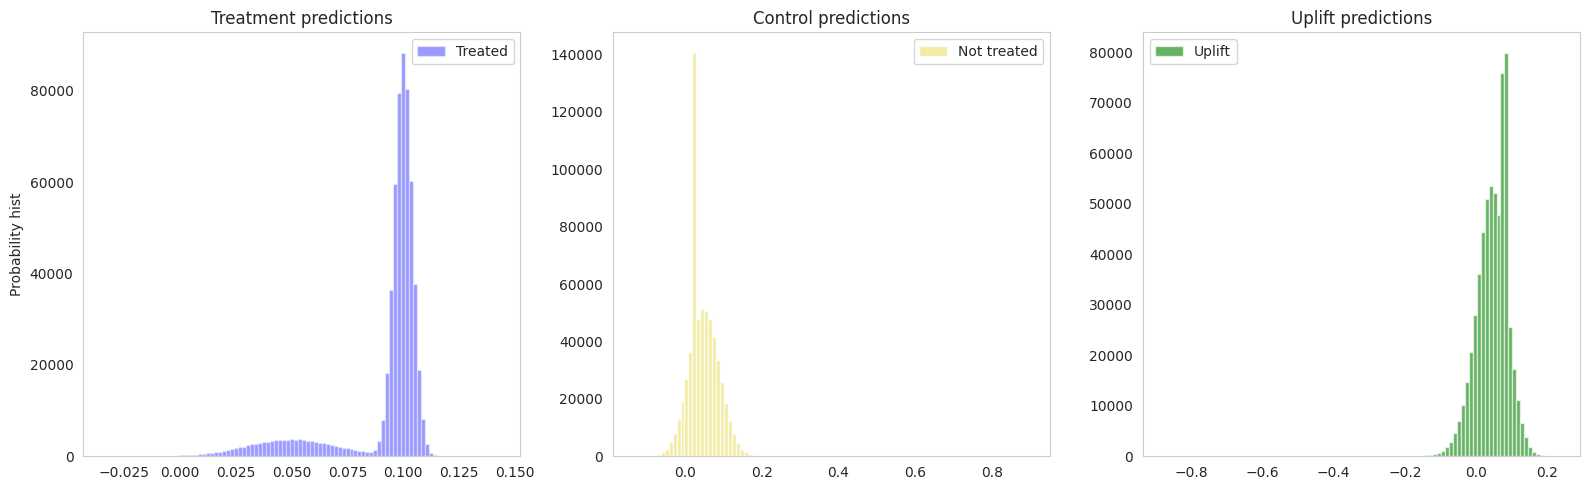

In [41]:
plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_)

plt.show()

Распределение предсказанного аплифта не очень похоже на нормальное. Заметим также, что модель редко предсказывает отрицательный аплифт, что не очень хорошо. Так мы не будем экономить на повышение бонусов.

Посмотрим топ 30 важных признаков для модели 

In [49]:
top_features = (
    pd.DataFrame({
        'feature_name': sm.estimator.feature_names_,
        'feature_score': sm.estimator.feature_importances_
    })
    .sort_values('feature_score', ascending=False)
    .head(30)  
    .reset_index(drop=True)
)

print(top_features)


                             feature_name  feature_score
0                               treatment      15.088739
1                                 plt_nan      12.506446
2                         cnt_trnx_ccr_1m       9.786862
3                          cnt_session_1m       6.576912
4                         cnt_trnx_gcs_1m       5.159707
5                avg_wrst_delqbalance_max       4.885505
6          ccr_account_first_open_dt_diff       4.636181
7                    first_appl_date_diff       4.285897
8                         avg_cred_av_log       3.413332
9                     last_appl_date_diff       3.390706
10  ccr_account_first_utilization_dt_diff       2.203067
11                        sum_trnx_cur_1m       2.173573
12                        avg_trnx_gcs_3m       1.991568
13                sum_out_payment_amt_rub       1.942347
14        sum_session_duration_sec_bnk_6m       1.697211
15                         cnt_session_7d       1.489972
16                        avg_t

Участие в акции (тритмент) внес наибольший вклад. 

Дополнительно поcмотрим на распределение относительного uplift. 

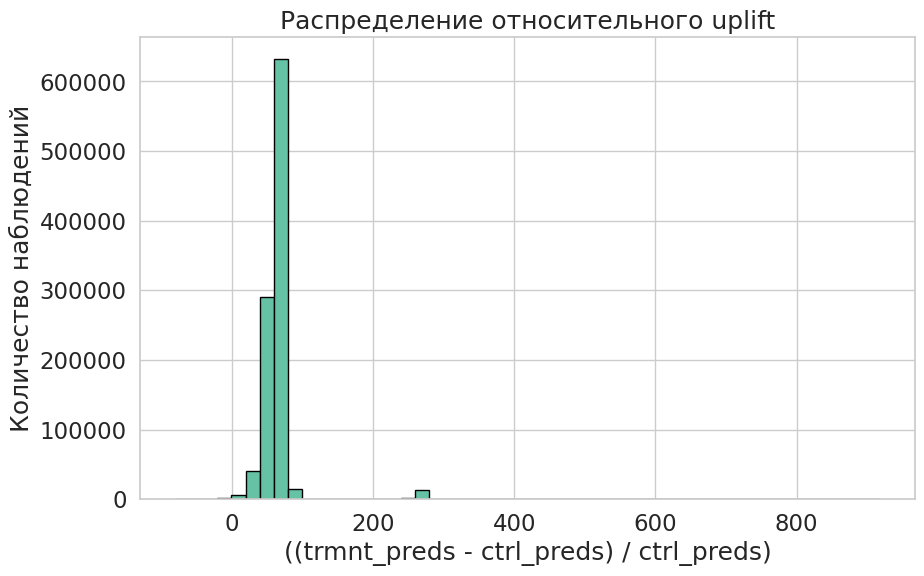

In [64]:
relative_uplift = ((sm.trmnt_preds_ - sm.ctrl_preds_) / sm.ctrl_preds_)*100

# Строим гистограмму
plt.figure(figsize=(10, 6))
pd.Series(relative_uplift).hist(bins=50, edgecolor='black')

plt.title('Распределение относительного uplift')
plt.xlabel('((trmnt_preds - ctrl_preds) / ctrl_preds)')
plt.ylabel('Количество наблюдений')
plt.grid(True)
plt.show()


2)  T-learner

In [72]:
train_df = X_train.copy()
train_df['target'] = y_train
train_df['treatment'] = treat_train
train_df_clean = train_df.dropna()
X_train_clean = train_df_clean.drop(columns=['target', 'treatment'])
y_train_clean = train_df_clean['target']
treat_train_clean = train_df_clean['treatment']


In [73]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)

tm = tm.fit(X_train_clean, y_train_clean, treat_train_clean)

In [75]:
uplift_tm = tm.predict(X_test)

Аналогично посомтрим на получившиеся распределения 

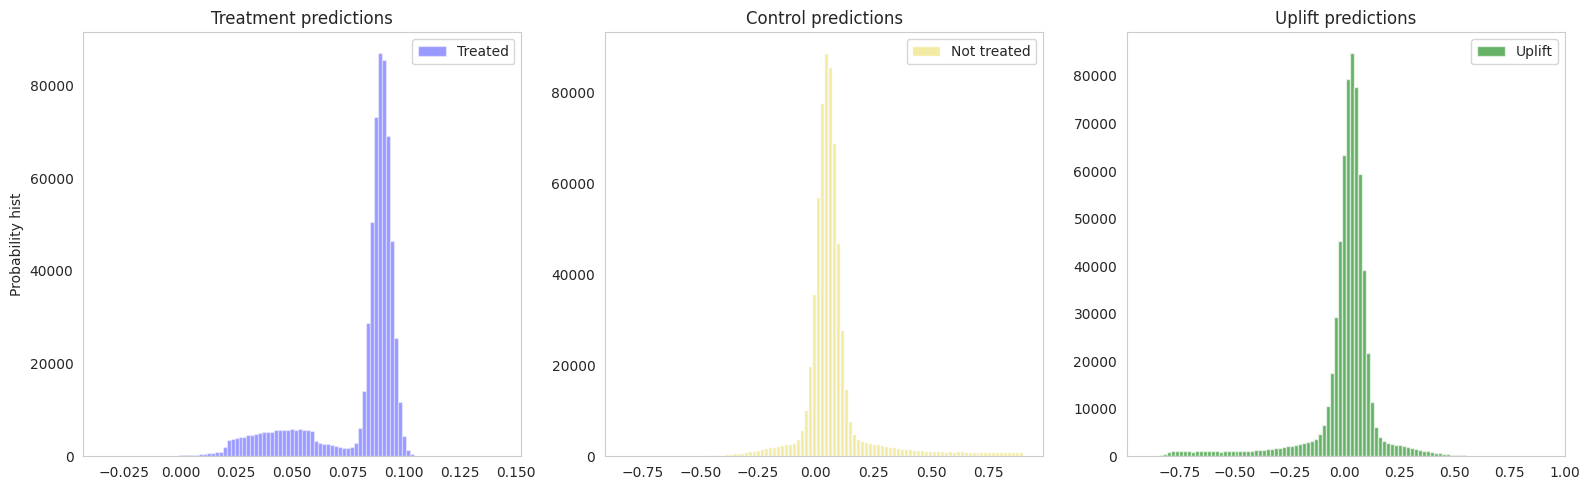

In [45]:
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

plt.show()

Предсказание для контрольнйо группы стало сильно больше походить на нормальное распределеение. Также модель стала чаще предсказывать отрицательный uplift.

Аналогично посомтрим на топ признаков по важности. 

In [80]:
importances_trmnt = tm.estimator_trmnt.feature_importances_
features = X_train_clean.columns

importances_ctrl = tm.estimator_ctrl.feature_importances_


feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance_treatment': importances_trmnt,
    'importance_control': importances_ctrl,
    'importance_diff': importances_trmnt - importances_ctrl
})

# Сортировка по абсолютной разнице важностей
feature_importance_df = feature_importance_df.sort_values('importance_diff', key=abs, ascending=False).reset_index(drop=True)


feature_importance_df.head(30)


,feature,importance_treatment,importance_control,importance_diff
0,plt_utl,0.000000,10.483922,-10.483922
1,sum_session_duration_sec_bnk_6m,13.141764,22.134931,-8.993167
2,max_trnx_3m,6.459753,0.196037,6.263716
3,cnt_trnx_ccr_1m,0.000000,4.604889,-4.604889
4,sum_delay_m1_cnt,4.436038,0.000000,4.436038
5,cnt_trnx_ccr_3m,3.800271,0.000000,3.800271
6,sum_session_duration_sec_1m,3.683848,0.000000,3.683848
7,ccr_account_first_utilization_dt_diff,7.444598,10.877954,-3.433356
8,max_trnx_inc_1m,0.000000,3.344818,-3.344818
9,appl_xsell_dozv_cnt,3.142299,0.000000,3.142299


3) x_learner

In [ ]:
x_learner = BaseXLearner(learner=CatBoostClassifier(iterations=100, silent=True))
assert X_train_np.shape[0] == y_train_np.shape[0] == treat_train_np.shape[0], "Несовпадение размеров!"
x_learner.fit(X=X_train, treatment=treat_train, y=y_train)



In [ ]:
X_test_np = X_test.values if hasattr(X_test, "values") else np.array(X_test)
uplift_x = x_learner.predict(X_test_np)

Посмотрим на распределения.

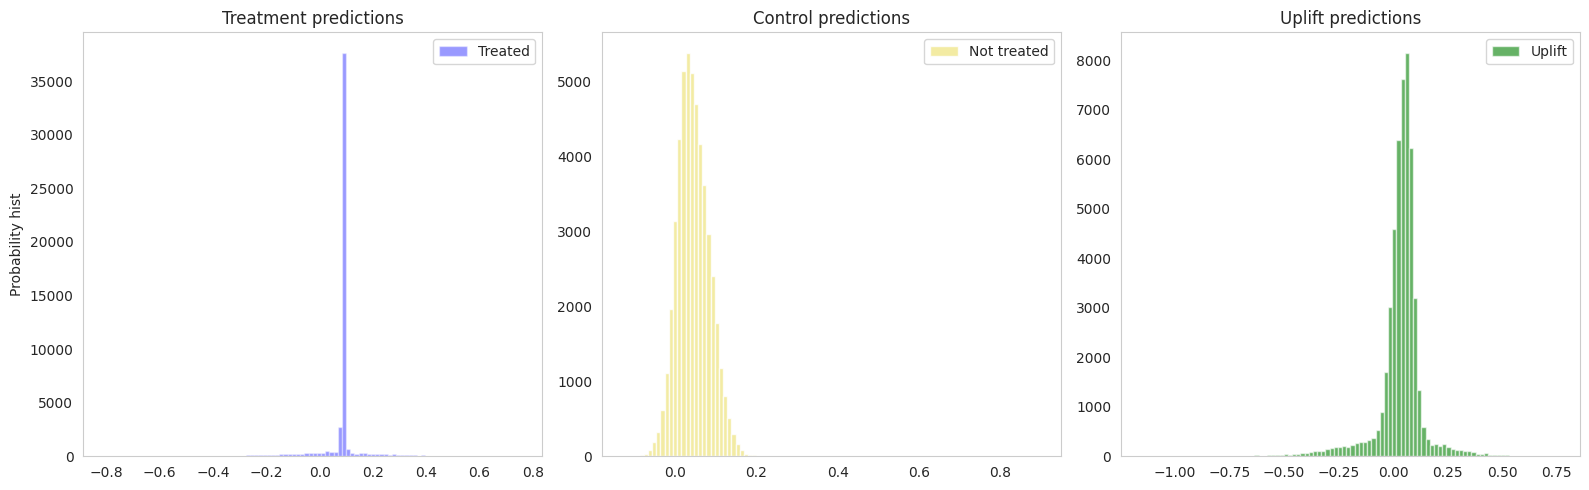

In [47]:
plot_uplift_preds(trmnt_preds=x_learner.trmnt_preds_, ctrl_preds=x_learner.ctrl_preds_)

plt.show()

Распредение стали еще больше походить на нормальные. Видно, что в предсказании uplift также присутствуют отрицательные значения. 

Далее выведем топ признаков по важности. 

In [51]:
importances_trmnt = x_learner.estimator_trmnt.feature_importances_
features = X_train_clean.columns

importances_ctrl = x_learner.estimator_ctrl.feature_importances_


feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance_treatment': importances_trmnt,
    'importance_control': importances_ctrl,
    'importance_diff': importances_trmnt - importances_ctrl
})

# Сортировка по абсолютной разнице важностей
feature_importance_df = feature_importance_df.sort_values('importance_diff', key=abs, ascending=False).reset_index(drop=True)


feature_importance_df.head(30)


                                  feature  importance
0         sum_session_duration_sec_bnk_6m   13.141764
1   ccr_account_first_utilization_dt_diff    7.444598
2                             max_trnx_3m    6.459753
3                               treatment    4.436038
4                         cnt_trnx_ccr_3m    3.800271
5             sum_session_duration_sec_1m    3.683848
6                     appl_xsell_dozv_cnt    3.142299
7                     trnx_purchase_share    3.075051
8                    avg_email_read_ratio    3.072816
9                    std_turnover_amt_rub    3.012778
10                         cnt_session_7d    3.008106
11                                blc_nan    2.930790
12                                avg_age    2.630607
13                   first_appl_date_diff    2.617926
14                        cnt_trnx_cur_3m    2.533772
15          appl_xsell_first_app_days_ago    2.036500
16                   cnt_session_1m_to_6m    2.002423
17                        cn

Продолжение в uplift_model2.ipynb